In [3]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
from gensim.models import word2vec

In [6]:
STATIC_PATH = '/home/elinha/NLP/moducon_data/phase_2'

china_file_name = 'intern_review_china.csv'
japan_file_name = 'intern_review_japan.csv'
korea_file_name = 'intern_review_korea.csv'
northAmerica_file_name = 'intern_review_northAmerica.csv'
color_list = ['FFFF00', 'BC002D', '0F64CD', 'B31942']
file_name_list = [china_file_name, japan_file_name, korea_file_name, northAmerica_file_name]
df_dict = {
    file_name.split('_')[-1].split('.')[0] : {
        "dataframe" : pd.read_csv(os.path.join(STATIC_PATH,file_name)),
        "color" : color
    }
    for color, file_name in zip(color_list, file_name_list)
    }

/tmp/ipykernel_1990276/1882730640.py:11: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  "dataframe" : pd.read_csv(os.path.join(STATIC_PATH,file_name)),


In [8]:
df_dict['china']['color']

'FFFF00'

In [7]:
df_dict['china']['dataframe']

,Reviewer,Review,Review_en,SeparatedSentences,ReviewDate
0,根,为什么就连在美国电影里，这么美这么成功的女性还是得接受一个如此平凡还出轨的丈夫？,Why even such a beautiful and successful woman...,Why even such a beautiful and successful woman...,2017-05-29 23:18:52
1,伊拉克洗衣粉,全靠德尼罗撑着。前半段好看，后半段价值观温吞保守又缩回去了。德尼罗的人设过于完美了一点,It all depends on De Niro.The first half looke...,It all depends on De Niro.The first half looke...,2015-10-04 11:42:38
2,朝阳区陆依萍,对我来说，每年能出一两部这样好看又能释放泪点的温馨小品，世界都会更美好.....,"For me, the world will be a better place if I ...","For me, the world will be a better place if I ...",2015-12-19 11:25:08
3,张佳玮,当年海瑟薇介入斯特里普的女强人生活，现在德尼罗反侵海瑟薇的生活……其实有点野心的，想讨论事业...,When Hathaway intervened in Streep's strongwom...,When Hathaway intervened in Streep's strongwom...,2016-01-25 21:14:56
4,同志亦凡人中文站,好久没看到安妮公主了，有种久别重逢的喜悦，但电影感觉就是麻麻，尤其在“时尚女魔头”把职业女性...,It's been a long time since I've seen Princess...,It's been a long time since I've seen Princess...,2015-09-24 19:25:27
...,...,...,...,...,...
3090,@user-hi7in1fu3x,你不觉得这跟之前的人.台词说的一模一样.这不是你的解说..你抄袭别人的,You don't think it's the same as the people be...,You're copying someone else.,NaN
3091,@liouball1499,笑死 高學歷沒用阿,"Laughing to death, higher education is useless.","Laughing to death, higher education is useless.",NaN
3092,@blackcatcaptain2022,女人作家和编剧，太浪漫的情节了,"Woman writer and screenwriter, too romantic.","Woman writer and screenwriter, too romantic.",NaN
3093,@denniswangcanada,你这个性冷淡的声音不适合解说这种轻喜剧，还有最后的那句话是什么鬼,Your cold voice is not suitable for explaining...,Your cold voice is not suitable for explaining...,NaN


# Preprocessing Strategy

1. Expand contractions : pycontractions
2. lowercase
3. change numbers to words : inflect
4. Remove Punctuations : '!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~'
5. Remove remained emoji, japanese, chinese, korean words
6. PoS_tagging: from nltk import pos_tag
7. If needed, remove PRP, TO, DT, etc. 
8. Stemming: PorterStemmer
9. Find out average sentence length
10. Wordcloud


In [52]:
# target_df 지정
target_country = 'japan'
target_df = df_dict[target_country]['dataframe']

In [53]:
# Pycontractions doesn't work due to dependency issue. I just modulized it by myself.

from contractions import expand_contractions

contracted_list = []
Sentences = target_df['SeparatedSentences'].copy()

for sentence in Sentences:
    expanded_sentence = expand_contractions(sentence)
    contracted_list.append(expanded_sentence)


In [11]:
contracted_list[:5]

['Why even such a beautiful and successful woman in American movies has to accept such an ordinary and cheating husband?',
 "It all depends on De Niro.The first half looked good, the second half values swallowed conservative and retreated.De Niro's people are a little too perfect.",
 'For me, the world will be a better place if I can make one or two such warm skits every year that look good and release tears.。。。。',
 "When Hathaway intervened in Streep's strongwoman life, now De Niro anti-invasion Hathaway life……actually a little ambitious, trying to discuss career women and the older generation, but floating a bit.I like Hathaway a lot, but every little expression of her has a sense of rehearsal and release, especially compared to De Niro's relaxed share.And De Niro is really handsome...…………",
 'it is been a long time since i have seen Princess Anne, but the movie feels numb, especially after "Fashion Witch" has set the bar so high for professional women and young people, it is also to

In [54]:
# Transform all sentences into lower case! easy!
contracted_list = [text.lower() for text in contracted_list]

In [ ]:
!pip install inflect

In [55]:
# Change numbers into words
import inflect
p = inflect.engine()

# 아라비아 숫자를 텍스트 숫자로 변경 5 -> five
def replace_number(match):
    number = match.group()
    return p.number_to_words(number)
    
def convert_number(text):
    converted_text = re.sub(r'\d+', replace_number, text)
    return converted_text

inflected_list = []
inflected_list = [convert_number(text) for text in contracted_list]         

In [56]:
# Remove punctuations
rm_punctionations = inflected_list.copy()

def rm_punct(text):
    cleaned_text = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@[\]。^_`{|}…~]', ' ', text)
    return cleaned_text

rm_punctionations = [rm_punct(text) for text in rm_punctionations]

In [57]:
# remove japanese, korean, chinese words

def only_english(text):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    return cleaned_text

rm_punctionations = [only_english(text) for text in rm_punctionations]

In [58]:
# POS_tagging

import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# 필요한 NLTK 데이터 다운로드
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Text를 단어 토큰과 POS 태그로 변환
def pos_tagging(text):
    word_tokens = word_tokenize(text)
    return pos_tag(word_tokens)

tag_sentence = rm_punctionations.copy()

tag_sentence = [pos_tagging(text) for text in tag_sentence]


[nltk_data] Downloading package punkt to /home/elinha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/elinha/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [17]:
nltk.download('tagsets')
nltk.help.upenn_tagset('WRB')

WRB: Wh-adverb
    how however whence whenever where whereby whereever wherein whereof why


[nltk_data] Downloading package tagsets to /home/elinha/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [59]:
# Remove IN, PRP, CC, PRP$, DT, TO, FW, WP
def remove_specific_tags(tagged_sentence, tags_to_remove):
    return [word for word, tag in tagged_sentence if tag not in tags_to_remove]

tags_to_remove = {"IN", "PRP", "CC", "PRP$", "DT", "TO", "FW", "WP", "WRB"}

tag_rm = tag_sentence.copy()
tag_rm = [remove_specific_tags(text, tags_to_remove) for text in tag_rm]

In [60]:
tag_rm_sentence = [pos_tag(sentence) for sentence in tag_rm]
tag_rm_sentence[:5]

[[('i', 'JJ'),
  ('think', 'VBP'),
  ('i', 'NNS'),
  ('have', 'VBP'),
  ('seen', 'VBN'),
  ('six', 'CD'),
  ('times', 'NNS'),
  ('is', 'VBZ'),
  ('kind', 'NN'),
  ('playing', 'VBG'),
  ('role', 'NN'),
  ('good', 'JJ'),
  ('grandpa', 'NN'),
  ('gentleman', 'NN'),
  ('does', 'VBZ'),
  ('not', 'RB'),
  ('seem', 'VB'),
  ('be', 'VB'),
  ('de', 'FW'),
  ('played', 'FW'),
  ('scary', 'JJ'),
  ('roles', 'NNS'),
  ('such', 'JJ'),
  ('alpacino', 'NN')],
 [('is', 'VBZ'),
  ('taxi', 'JJ'),
  ('driver', 'RB'),
  ('s', 'JJ'),
  ('movie', 'NN'),
  ('i', 'NN'),
  ('am', 'VBP'),
  ('going', 'VBG'),
  ('be', 'VB'),
  ('driver', 'RB')],
 [('is', 'VBZ'),
  ('very', 'RB'),
  ('good', 'JJ'),
  ('movie', 'NN'),
  ('warms', 'NNS'),
  ('heart', 'NN'),
  ('motivates', 'NNS')],
 [('i', 'NN'),
  ('finished', 'VBD'),
  ('watching', 'VBG'),
  ('i', 'NN'),
  ('was', 'VBD'),
  ('filled', 'VBN'),
  ('happiness', 'RB'),
  ('all', 'DT'),
  ('characters', 'NNS'),
  ('are', 'VBP'),
  ('attractive', 'JJ'),
  ('live', 'JJ'

In [61]:
# Lemmatize & remove stopwords

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.corpus import wordnet as wn

nltk.download('wordnet')

# inflect engine initialize
p = inflect.engine()

# WordNetLemmatizer initialize
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return None

def singularize_and_lemmatize(tagged_words):
    new_words = []
    
    for word, tag in tagged_words:
        if tag.startswith('N'):
            singular_word = p.singular_noun(word)
            if singular_word:
                new_words.append(singular_word)
            else:
                new_words.append(word)
        else:
            wn_tag = get_wordnet_pos(tag)
            if wn_tag is not None:
                lemma_word = lemmatizer.lemmatize(word, wn_tag)
                new_words.append(lemma_word)
            else:
                new_words.append(word)
    
    return new_words

[nltk_data] Downloading package wordnet to /home/elinha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [62]:
processed_sentences = [singularize_and_lemmatize(sentence) for sentence in tag_rm_sentence]

In [63]:
# stopwords
def remove_verbs(words):
    verbs_to_remove = {"i", "am", "be", "are", "was", "were", "being", "is"}
    filtered_words = [word for word in words if word not in verbs_to_remove]
    return filtered_words

processed_sentences_no_stopwords = [remove_verbs(word) for word in processed_sentences]

In [64]:
# final..refine!

def replace_words(sentence):
    replacements = {
        r'\binternben\b': ['intern', 'ben'],
        r'\bexperiencesben\b': ['experience', 'ben'],
        r'\bbeingben\b': ['being', 'ben'],
        r'\bbentwo\b': ['ben', 'two'],
        r'\bbens\b': ['ben'],
        r'\bitben\b': ['it', 'ben'],
        r'\bheartben\b': ['heart', 'ben'],
        r'\botherben\b': ['other', 'ben'],
        r'\bbentheir\b': ['ben', 'their'],
        r'\bfamilyben\b': ['family', 'ben'],
        r'\bfunben\b': ['fun', 'ben'],
        r'\binternrobert\b': ['intern', 'robert'],
        r'\buprobert\b': ['up', 'robert'],
        r'\brealisticrobert\b': ['realistic', 'robert'],
        r'\btemperrobert\b': ['temper', 'robert'],
        r'\bplacerobert\b': ['place', 'robert'],
        r'\btimesrobert\b': ['time', 'robert'],
        r'\bniros\b': ['niro'],
        r'\bdeniro\b': ['niro'],
        r'\bniroi\b': ['niro', 'I'],
        r'\bmyershe\b': ['she'],
        r'\bmyersworking\b': ['working'],
        r'\banhathaway\b': ['hathaway'],
        r'\bsceneanhathaway\b': ['scene', 'hathaway'],
        r'\banhathawayhis\b': ['hathaway', 'his'],
        r'\bhathawayde\b': ['hathaway', 'de'],
        r'\bhathaways\b': ['hathaway'],
        r'\banhathaways\b': ['hathaway'],
        r'\brottenanhathaway\b': ['rotten', 'hathaway'],
        r'\btherejules\b': ['there', 'jule'],
        r'\bweakjule\b': ['weak', 'jule'],
        r'\bjules\b': ['jule'],
        r'\broutinejule\b': ['routine', 'jule'],
        r'\bagejule\b': ['age', 'jule'],
    }
    for pattern, replacement in replacements.items():
        sentence = re.sub(pattern, ' '.join(replacement), sentence)

    return sentence.split()

modified_sentences = [replace_words(' '.join(sentence)) for sentence in processed_sentences_no_stopwords]

In [65]:
# remove empty list, remove words with len=1
modified_sentences = [sentence for sentence in modified_sentences if len(sentence) > 1]

In [66]:
lengths = [len(sentence) for sentence in modified_sentences]

# sentence lenths discriptive analysis
median = np.median(lengths)
mean = np.mean(lengths)
percentile_75 = np.percentile(lengths, 75)
percentile_90 = np.percentile(lengths, 90)
percentile_95 = np.percentile(lengths, 95)

print ('median: ', median, 
       'mean: ', mean, 
       'per_75: ', percentile_75, 
       'per_90: ', percentile_90, 
       'per_95: ', percentile_95)

median:  8.0 mean:  11.011345878910795 per_75:  14.0 per_90:  22.0 per_95:  29.0


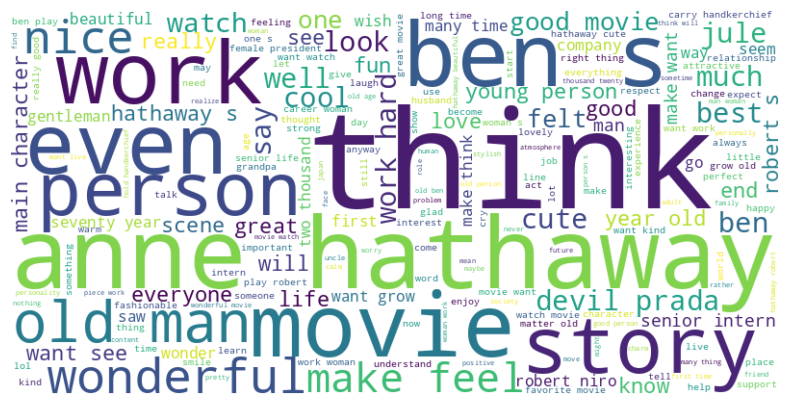

In [67]:
#wordcloud
from wordcloud import WordCloud
text_data_china = " ".join([" ".join(sentence) for sentence in modified_sentences])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data_china)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [68]:
from collections import Counter
all_words = [word for sentence in modified_sentences for word in sentence]
word_freq= Counter(all_words)

In [69]:
df_word_freq = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])
df_word_freq.sort_values(by='Frequency', ascending=False, inplace=True)
df_word_freq

,Word,Frequency
12,not,25710
22,movie,25322
41,work,23583
1,have,23171
39,want,21181
...,...,...
9107,higaamerica,1
9106,christiezaire,1
9105,higatwo,1
9104,stark,1


# word2Vec

In [30]:
from gensim.models import Word2Vec

In [70]:
model = Word2Vec(sentences=modified_sentences, vector_size=100, window=46, min_count=2, workers=1)

In [71]:
word_vectors = model.wv

In [72]:
similar_words = word_vectors.most_similar('intern')
print(similar_words)

[('internship', 0.8103858232498169), ('citizen', 0.7205187678337097), ('program', 0.6856791973114014), ('startup', 0.6660732626914978), ('apply', 0.6563963294029236), ('venture', 0.6383678317070007), ('apparel', 0.6372349858283997), ('hire', 0.6347476840019226), ('employ', 0.6327304840087891), ('system', 0.6275866031646729)]


In [73]:
similar_words_100 = word_vectors.most_similar('ben', topn=100)
print("Top 100 similar words:", similar_words_100)


Top 100 similar words: [('initially', 0.5428270697593689), ('gradually', 0.5380387902259827), ('trust', 0.5284274816513062), ('concern', 0.5174960494041443), ('colleague', 0.5119839906692505), ('consult', 0.5093748569488525), ('trusted', 0.5057209730148315), ('consideration', 0.5052237510681152), ('sincerity', 0.5008603930473328), ('personality', 0.49509453773498535), ('sincere', 0.4856596291065216), ('observation', 0.48431161046028137), ('instead', 0.46924781799316406), ('attitude', 0.461587131023407), ('communicate', 0.45691415667533875), ('reveal', 0.44776928424835205), ('generosity', 0.4477522671222687), ('treat', 0.4476297199726105), ('involve', 0.44699403643608093), ('extensive', 0.4429493844509125), ('accurate', 0.44210511445999146), ('etho', 0.441756933927536), ('distance', 0.43896549940109253), ('respond', 0.43881216645240784), ('unfamiliar', 0.43615612387657166), ('behavior', 0.43477877974510193), ('directly', 0.4344666302204132), ('dislike', 0.4333893358707428), ('interchang

In [46]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [74]:
keyword_file_name = f'keywords_cnt_{target_country}.csv'

In [75]:
df_word_freq = pd.read_csv(os.path.join(STATIC_PATH,'keyword', keyword_file_name))

In [76]:
df_word_freq_new = df_word_freq[df_word_freq['count']>1]

In [77]:
old_words = ['ben', 'senior', 'old', 'elderly', 'elder']
young_words = ['jule', 'junior', 'young']

In [41]:
pos_words = [
    "gentleman", "strong", "handsome", "smart", "intelligent", "succes", "successful",
    "healthy", "kindness", "powerful", "talented", "charm", "courage", "encourage", "respect", "respectful"
    "gentle", "brave", "optimistic", "warmth", "friendly", "attractive", "sympathetic",
    "victorious", "hero", "heroine", "courteous", "wise", "wisdom", "passion", "passionate", "lovely", "beloved"
]
neg_words = [
    "arrogant", "hypocritical", "unscrupulous", "stupid", "childish", 
    "betrayal", "bully", "angry", "fearful", "rude", "untrustworthy", 
    "stubborn", "tacky", "negative", "annoying", "selfish", "shameful", 
    "ridiculous", "pathetic"
]

In [78]:
# cosine similarity 
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = np.array([cos_sim(w, a) for a in A])
    c_b = np.array([cos_sim(w, b) for b in B])
    mean_A = np.mean(c_a)
    mean_B = np.mean(c_b)
    return mean_A - mean_B

# Target A - Target B
def s_group(X, A, B):
    return np.array([s(x, A, B) for x in X])

#WEAT
def weat_score(X, Y, A, B):
    s_X = s_group(X, A, B)
    s_Y = s_group(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return (mean_X - mean_Y) / std_dev

In [79]:
X = np.array([model.wv.get_vector(word) for word in old_words if word in model.wv])
Y = np.array([model.wv.get_vector(word) for word in young_words if word in model.wv])
A = np.array([model.wv.get_vector(word) for word in pos_words if word in model.wv])
B = np.array([model.wv.get_vector(word) for word in neg_words if word in model.wv])

In [80]:
# WEAT score result
weat_result = round(weat_score(X, Y, A, B), 3)
print("WEAT Score:", weat_result)

WEAT Score: 0.824


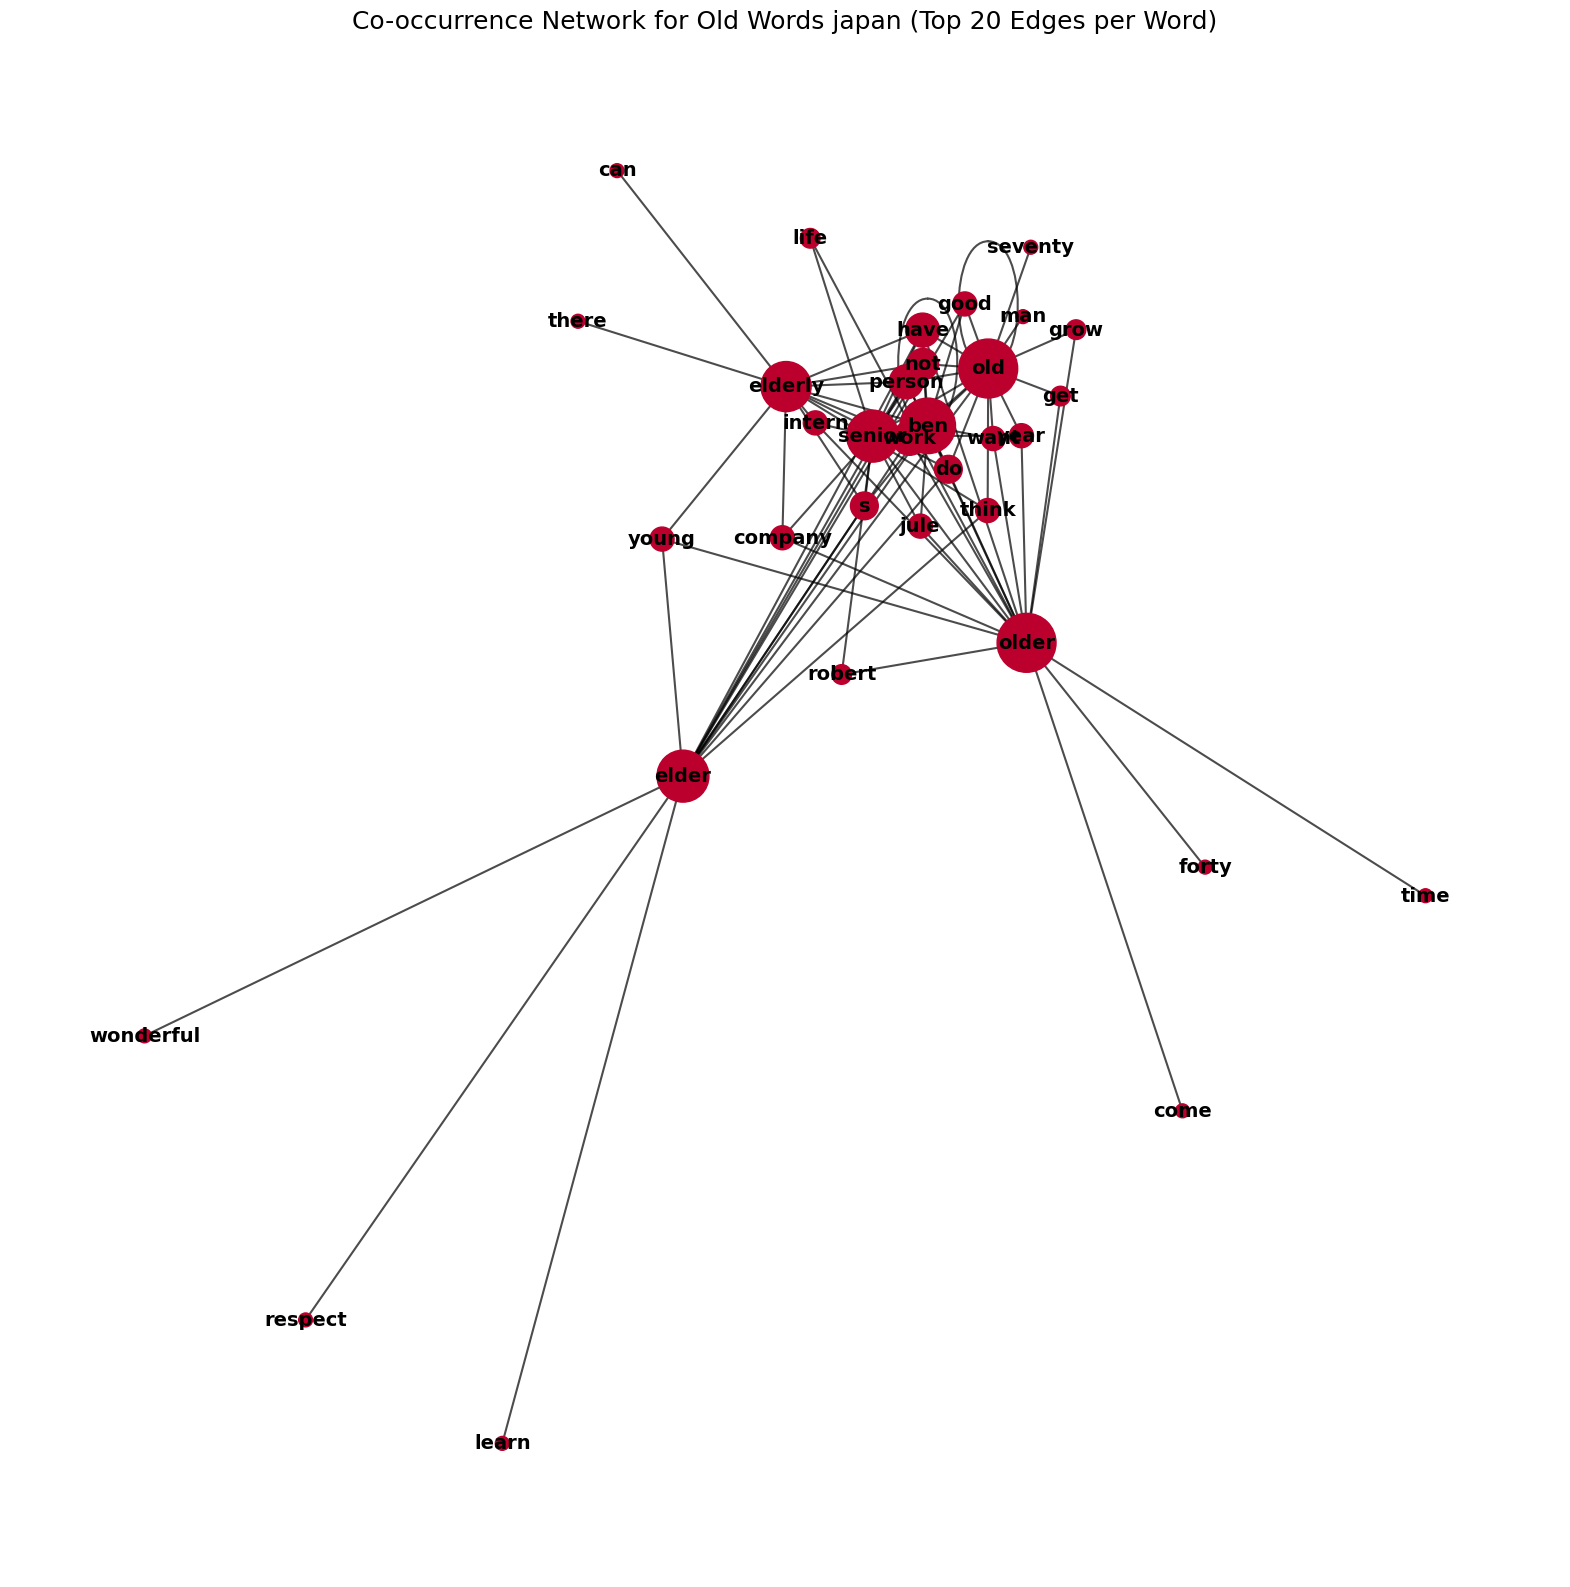

In [81]:
import itertools
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

old_words = ['ben', 'senior', 'old', 'older', 'elderly', 'elder']
young_words = ['jule', 'young', 'younger', 'youngster']

co_occurrence = defaultdict(int)

window_size = 20

for sentence in modified_sentences:
    effective_window_size = min(len(sentence), window_size)
    for i in range(len(sentence)):
        window = sentence[i:i+effective_window_size]
        for pair in itertools.combinations(window, 2):
            co_occurrence[pair] += 1
            
# Create the graph
G = nx.MultiGraph()

for (word1, word2), weight in co_occurrence.items():
    G.add_edge(word1, word2, weight=weight)

relevant_words = set(old_words + young_words)
filtered_edges = [(u, v, d) for u, v, d in G.edges(data=True) if u in relevant_words or v in relevant_words]

H = nx.Graph()
H.add_edges_from(filtered_edges)

H_old_filtered = nx.Graph()

for word in old_words:
    edges_for_word = [(u, v, d) for u, v, d in G.edges(data=True) if (u == word or v == word)]
    sorted_edges = sorted(edges_for_word, key=lambda x: x[2]['weight'], reverse=True)[:20]
    H_old_filtered.add_edges_from(sorted_edges)

# Visualization of the subgraph related to old words
plt.figure(figsize=(20,20))

# Adjust the spring layout for better node spacing
pos_old_filtered = nx.spring_layout(H_old_filtered, seed=42, k=0.8)

# Node sizes based on the number of edges (degree) connected to them
node_sizes = [H_old_filtered.degree(node) * 100 for node in H_old_filtered.nodes()]

# Node colors using HEX values (e.g., light blue)
node_colors = [f"#{df_dict[target_country]['color']}" for _ in H_old_filtered.nodes()]  # Use your desired HEX color here

# Draw nodes, edges, and labels with improved readability
nx.draw_networkx_nodes(H_old_filtered, pos_old_filtered, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_edges(H_old_filtered, pos_old_filtered, width=1.5, alpha=0.7)
nx.draw_networkx_labels(H_old_filtered, pos_old_filtered, font_size=14, font_family="sans-serif", font_weight='bold')

plt.title(f"Co-occurrence Network for Old Words {target_country} (Top 20 Edges per Word)", fontsize=18)
plt.axis("off")
plt.show()